In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('../data/us_election.csv')

In [3]:
data.head()

,STATEFP,COUNTYFP,GEOID,ALAND,AWATER,area_name,state_abbr,PST045214,PST040210,PST120214,...,Demvotes12,GOPvotes12,county_fip,state_fips,pct_dem_12,pct_gop_12,diff_2012,pct_pt_12,lon,lat
0,1,5,1005,2291820706,50864677,Barbour County,AL,26887,27457,-2.1,...,5873,5539,5,1,0.512523,0.483376,334,0.029147,-85.393211,31.869580
1,1,23,1023,2365954971,19059247,Choctaw County,AL,13323,13858,-3.9,...,3785,4150,23,1,0.475204,0.521030,365,-0.045825,-88.263180,32.019772
2,1,35,1035,2201896058,6643480,Conecuh County,AL,12670,13228,-4.2,...,3551,3434,35,1,0.506345,0.489662,117,0.016683,-86.993674,31.429234
3,1,51,1051,1601876535,99850740,Elmore County,AL,80977,79296,2.1,...,8940,26223,51,1,0.252257,0.739927,17283,-0.487669,-86.149159,32.596647
4,1,65,1065,1667804583,32525874,Hale County,AL,15184,15760,-3.7,...,5401,3205,65,1,0.625985,0.371465,2196,0.254520,-87.629146,32.762664


In [4]:
dem_pct = data['pct_dem_16']

In [5]:
features = data[['PST045214', 'AGE135214', 'AGE295214', 'AGE775214', 'SEX255214', 'RHI125214',
                 'RHI225214', 'RHI425214', 'RHI525214', 'RHI725214', 'POP645213',
                 'POP815213', 'EDU635213', 'EDU685213', 'VET605213', 'LFE305213', 'INC110213',
                 'PVY020213', 'SBO001207', 'RTN131207']]

In [6]:
loc = data[['lon', 'lat']]

In [7]:
X_train, X_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(features, dem_pct, loc, train_size=0.8, random_state=42)

In [8]:
X_calib, X_test, y_calib, y_test, loc_calib, loc_test = train_test_split(X_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

In [9]:
model = xgb.XGBRegressor(n_estimators=400, max_depth=3, min_child_weight=0.8, colsample_bytree=0.8)

In [10]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=0.8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
model.score(X_test, y_test)

0.7898821455768755

In [12]:
explainer = GeoConformalizedExplainer(model, X_train, X_calib, loc_calib.values, loc_test.values, 0.1, 3)

In [13]:
results = explainer.uncertainty_aware_explain(x_test=X_test)

Training SHAP


PermutationExplainer explainer: 2487it [09:01,  4.56it/s]                          


Calibrating SHAP


PermutationExplainer explainer: 312it [01:00,  4.30it/s]                         


Testing SHAP


PermutationExplainer explainer: 312it [00:59,  4.31it/s]                         


Explaining Variables


C:\Users\Xiayin\PycharmProjects\UncertaintyGeoXAI\GeoConformalizedExplainer\GeoConformalizedExplainer.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature_name}_geo_uncertainty'] = geocp_result.geo_uncertainty
C:\Users\Xiayin\PycharmProjects\UncertaintyGeoXAI\GeoConformalizedExplainer\GeoConformalizedExplainer.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature_name}_uncertainty'] = geocp_result.uncertainty
C:\Users\Xiayin\PycharmProjects\UncertaintyGeoXAI\GeoConformalizedExplainer\GeoConformalizedEx

In [14]:
results.accuracy_summary()

,coverage_probability,R2,RMSE,SHAP_Var,Pred_SHAP_Var
PST045214,0.887460,0.892332,0.013520,0.001698,0.001901
AGE135214,0.919614,0.579796,0.005290,0.000067,0.000041
AGE295214,0.954984,0.949095,0.008958,0.001576,0.001713
AGE775214,0.906752,0.696245,0.006924,0.000158,0.000088
SEX255214,0.900322,0.690081,0.008095,0.000211,0.000159
RHI125214,0.868167,0.960012,0.014288,0.005105,0.004124
RHI225214,0.893891,0.866461,0.007806,0.000456,0.000359
RHI425214,0.877814,0.607032,0.008885,0.000201,0.000149
RHI525214,0.890675,0.491021,0.003697,0.000027,0.000020
RHI725214,0.926045,0.852061,0.012217,0.001009,0.001037


In [19]:
results.accuracy_summary().to_csv('./USElection_accuracy_summary.csv')

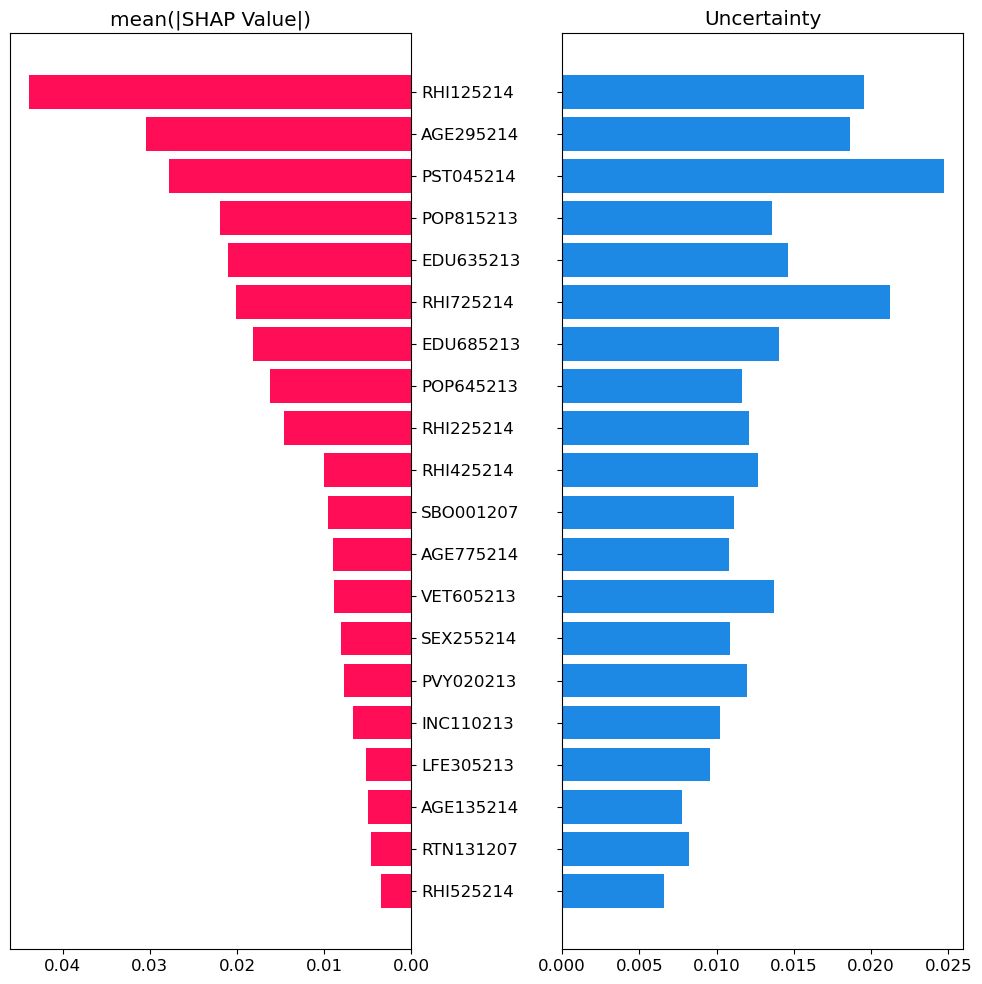

In [15]:
results.plot_absolute_shap_value_with_uncertainty(filename='./USElection_absolute_shap_value_with_uncertainty.pdf')

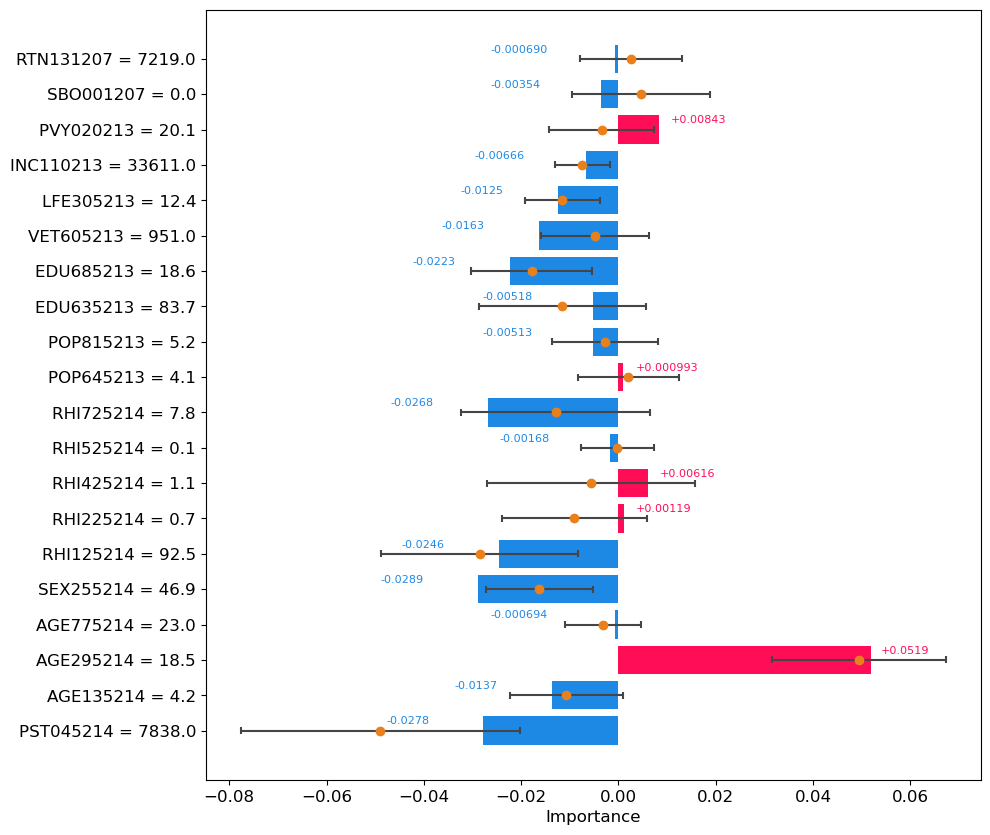

In [16]:
 results.plot_shap_values_with_uncertainty(10, filename='./USElection_shap_values_with_uncertainty.pdf')

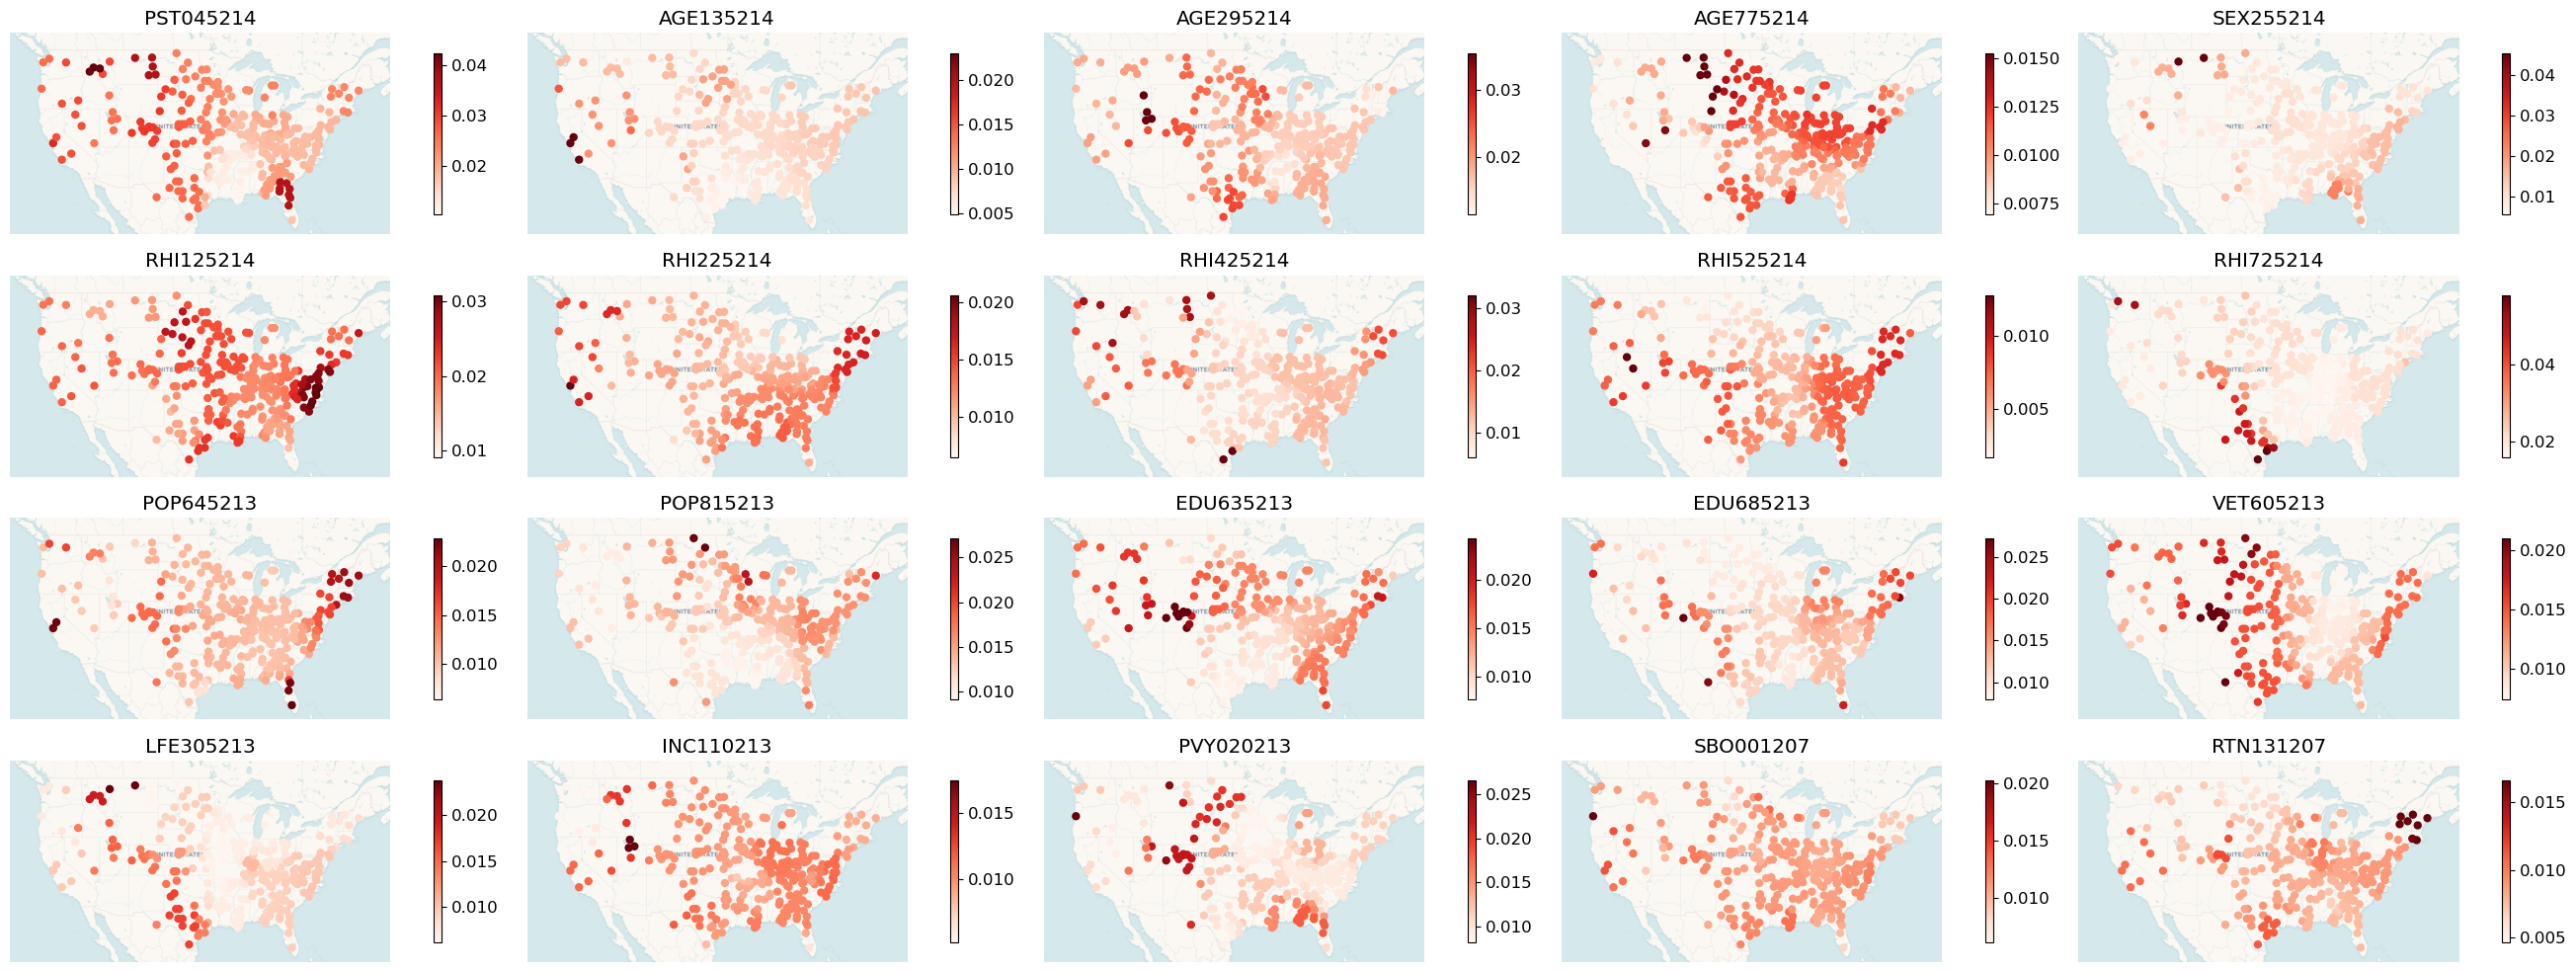

In [17]:
results.plot_geo_uncertainty(figsize=(30, 10), shrink=0.8, filename='USElection_geo_uncertainty.pdf')

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

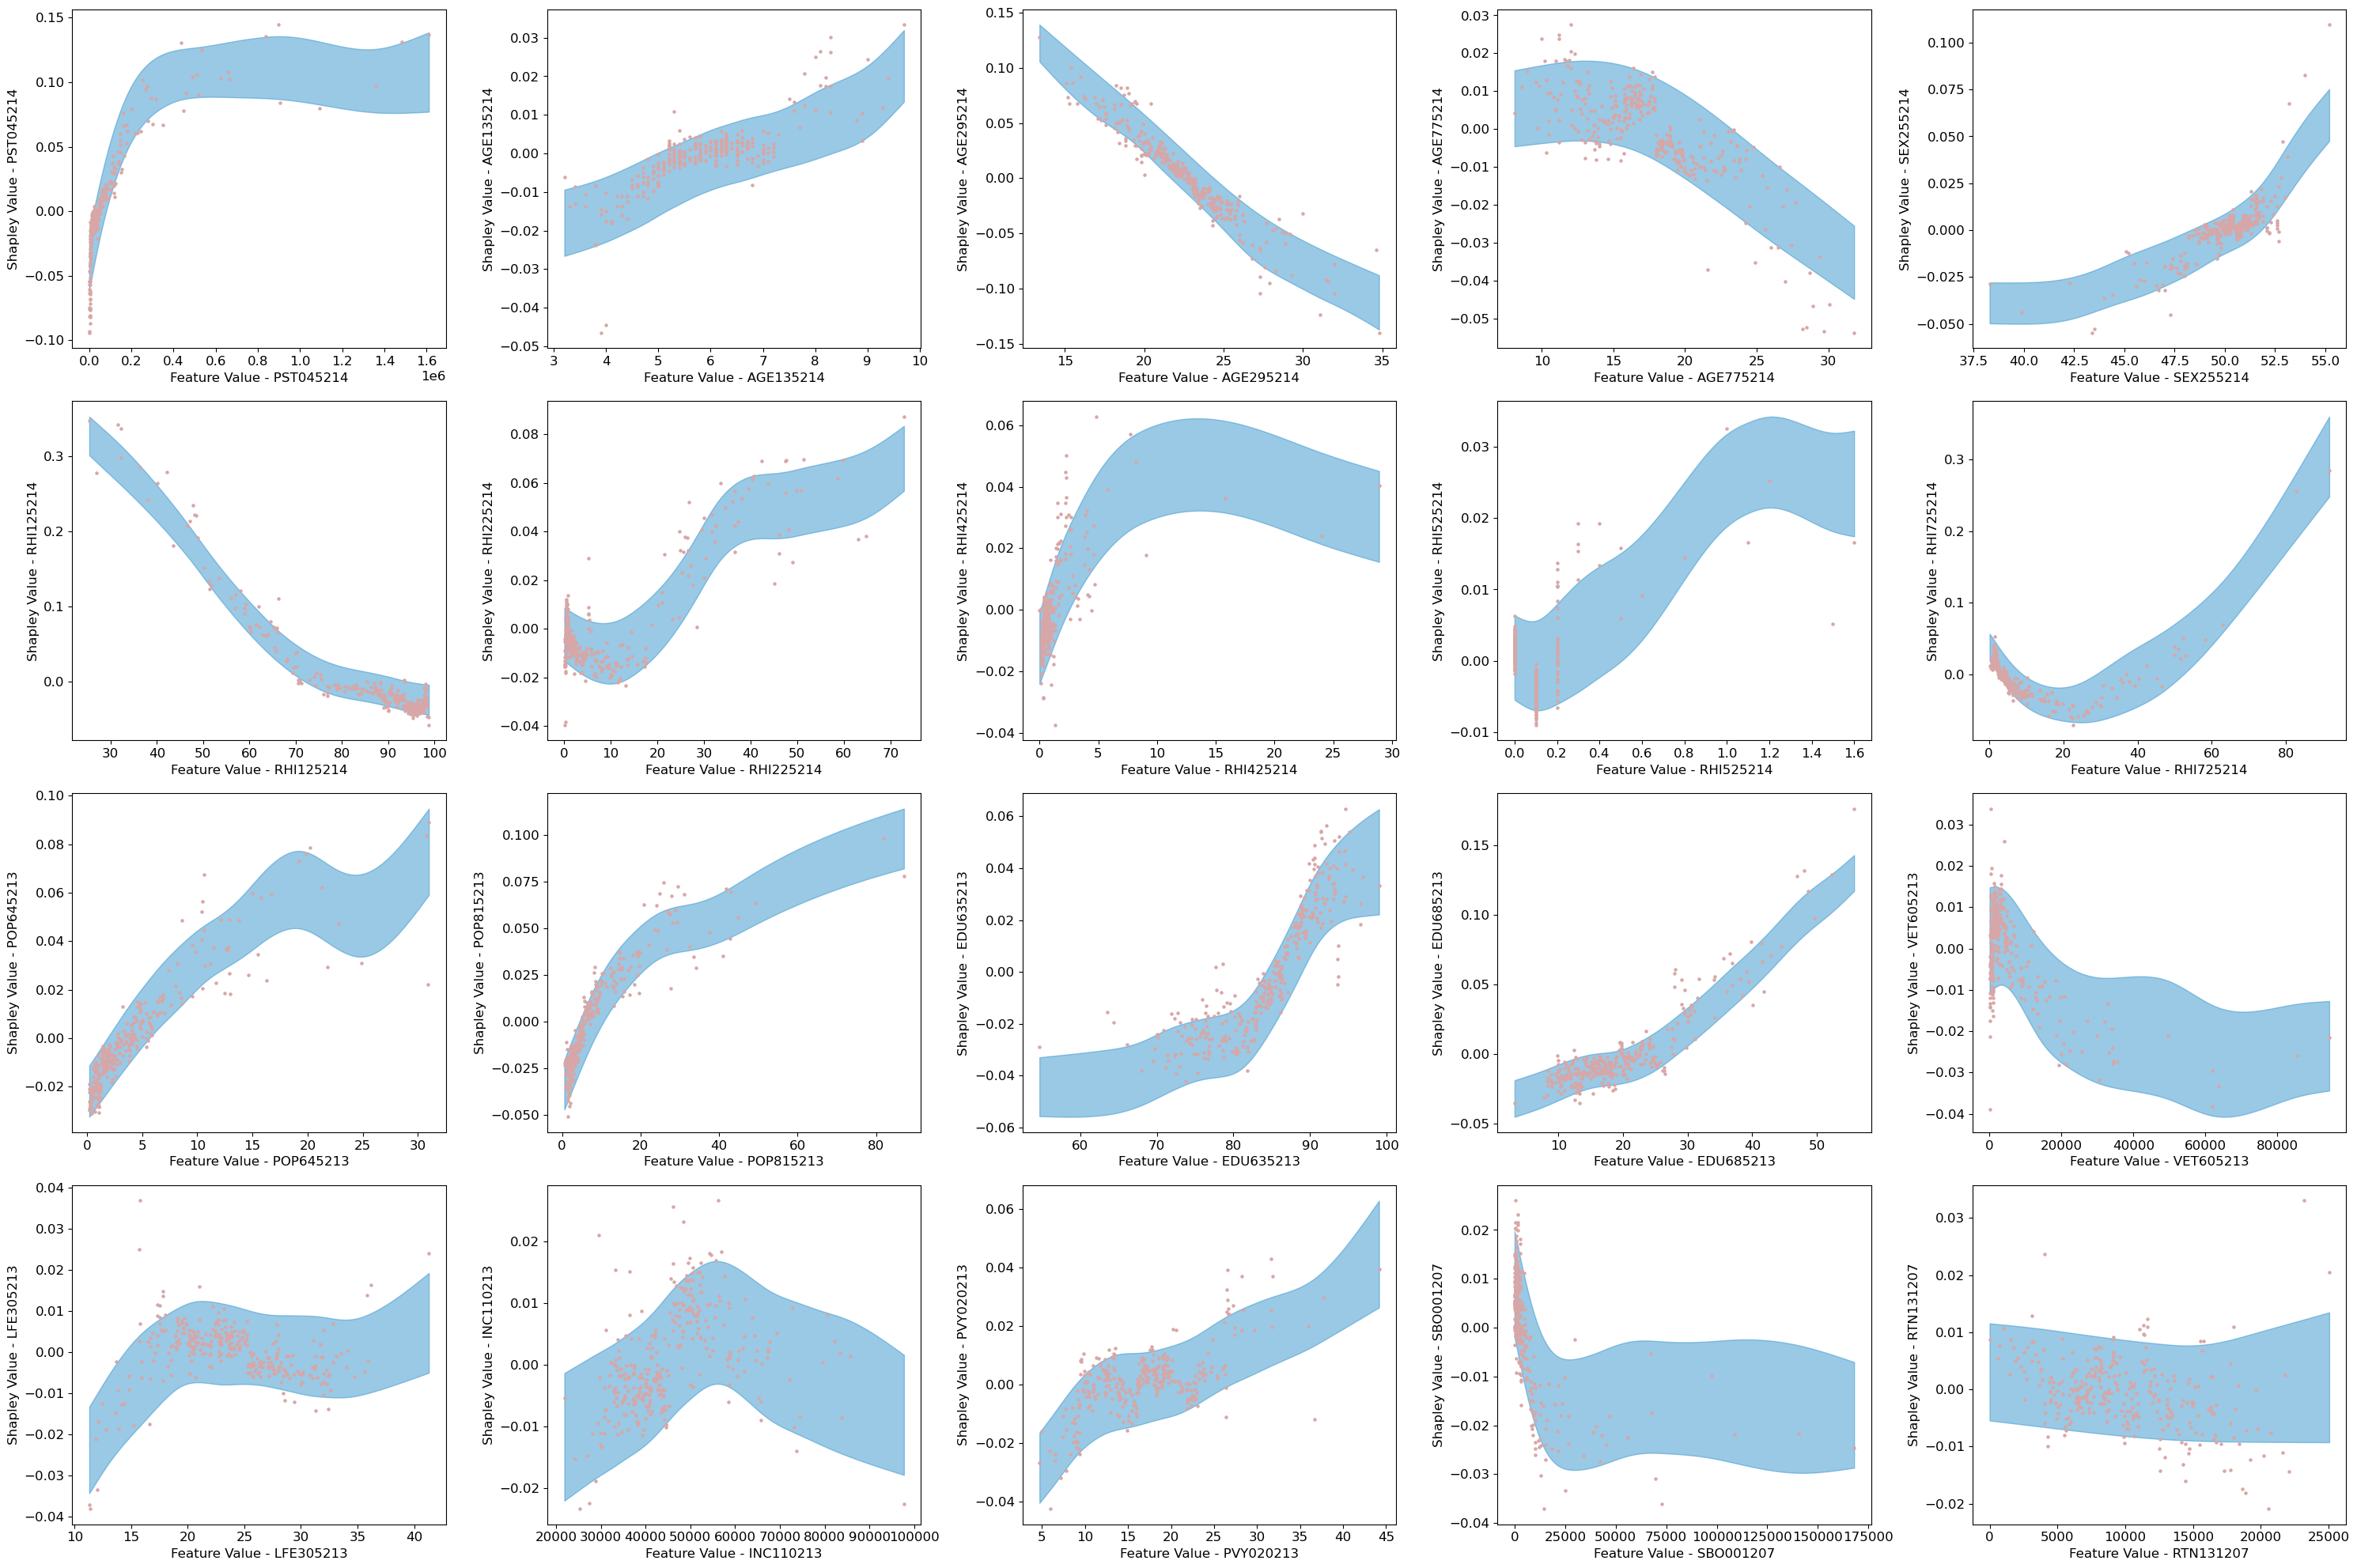

In [18]:
results.plot_partial_dependence_with_fitted_bounds(filename='USElection_partial_dependence_with_fitted_bounds.pdf')